In [1]:
# import Libraries
import sqlite3
import warnings

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from category_encoders import OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.utils.validation import check_is_fitted

warnings.simplefilter(action="ignore", category=FutureWarning)

# Import

I'll import the data and clean it using the wrangle function from the first notebook.

In [2]:
def wrangle(db_path):
    # Connect to database
    conn = sqlite3.connect(db_path)

    # Construct query
    query = """
        SELECT distinct(i.building_id) AS b_id,
           s.*,
           d.damage_grade
        FROM id_map AS i
        JOIN building_structure AS s ON i.building_id = s.building_id
        JOIN building_damage AS d ON i.building_id = d.building_id
        WHERE district_id = 4
    """

    # Read query results into DataFrame
    df = pd.read_sql(query, conn, index_col="b_id")
    
    # Identify Leaky Columns
    drop_cols = [col for col in df.columns if "post_eq" in col]
    
    # Create Binary target
    df["damage_grade"] = df["damage_grade"].str[-1].astype(int)
    df["severe_damage"]= (df["damage_grade"]> 3).astype(int)
    
    # Drop Old Target
    drop_cols.append("damage_grade")
    
    # Drop multicolinearity column
    drop_cols.append("count_floors_pre_eq")
    
    # Drop high cardinality column
    drop_cols.append("building_id")
    
    # Drop Columns
    df.drop(columns=drop_cols, inplace=True)
    
    
    return df


In [3]:
df = wrangle("/home/linuxdavid/Machine_Learning_Specialization/WQU/EarthQuake/nepal.sqlite")

df.head()

,age_building,plinth_area_sq_ft,height_ft_pre_eq,land_surface_condition,foundation_type,roof_type,ground_floor_type,other_floor_type,position,plan_configuration,superstructure,severe_damage
b_id,,,,,,,,,,,,
164002,20,560,18,Flat,Mud mortar-Stone/Brick,Bamboo/Timber-Light roof,Mud,TImber/Bamboo-Mud,Not attached,Rectangular,"Stone, mud mortar",0
164081,21,200,12,Flat,Mud mortar-Stone/Brick,Bamboo/Timber-Light roof,Mud,TImber/Bamboo-Mud,Not attached,Rectangular,"Stone, mud mortar",0
164089,18,315,20,Flat,Mud mortar-Stone/Brick,Bamboo/Timber-Light roof,Mud,TImber/Bamboo-Mud,Not attached,Rectangular,"Stone, mud mortar",0
164098,45,290,13,Flat,Mud mortar-Stone/Brick,Bamboo/Timber-Light roof,Mud,TImber/Bamboo-Mud,Not attached,Rectangular,"Stone, mud mortar",0
164103,21,230,13,Flat,Mud mortar-Stone/Brick,Bamboo/Timber-Light roof,Mud,TImber/Bamboo-Mud,Not attached,Rectangular,"Stone, mud mortar",0


# Split

In [4]:
# Create feature matrix X and target vector y. 
# Recall the target is "severe_damage"
target = "severe_damage"
X = df.drop(columns=target)
y = df[target]

In [5]:
# Perform a randomized train_test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)

X_train shape: (56668, 11)
y_train shape: (56668,)
X_test shape: (14168, 11)
y_test shape: (14168,)


# Build Model

## Baseline

Considering this is a classification problem, the performace matric i'll focus on for this task is Accuracy score.
Accuracy is equal to the number of observations you correctly classified over all observations. For example, if your model properly identified 77 out of 100 images, you have an accuracy of 77%. Accuracy is an easy metric to both understand and calculate. Mathematically, it is simply

$$ \frac{\text{number of correct observations}}{\text{number of observations}}.$$


In [6]:
acc_baseline = y_train.value_counts(normalize=True).max()
print("Baseline Accuracy:", round(acc_baseline, 2))

Baseline Accuracy: 0.64


# Iterate

In [8]:
# Create a pipeline named model that contains a
# OneHotEncoder transformer and a LogisticRegression predictor

# Build model
model = make_pipeline(
    OneHotEncoder(use_cat_names=True), 
    LogisticRegression(max_iter=2000) # set max_iter between 1000 and 3000 to avoid a convergence warning
)
# Fit model to training data
model.fit(X_train, y_train)


Pipeline(steps=[('onehotencoder',
                 OneHotEncoder(cols=['land_surface_condition',
                                     'foundation_type', 'roof_type',
                                     'ground_floor_type', 'other_floor_type',
                                     'position', 'plan_configuration',
                                     'superstructure'],
                               use_cat_names=True)),
                ('logisticregression', LogisticRegression(max_iter=2000))])

# Evaluate

Accuracy score ranges from 0 to 1 and the goal here is for the model to beat the baseline score of 0.64

In [9]:
# Calculate the training and test accuracy scores for the training and test models.
acc_train = accuracy_score(y_train, model.predict(X_train))
acc_test = accuracy_score(y_test, model.predict(X_test))

print("Training Accuracy:", round(acc_train, 2))
print("Test Accuracy:", round(acc_test, 2))

Training Accuracy: 0.71
Test Accuracy: 0.72


Next i'll extract the feature names and importances from the model
* Feature names refer to the names of the variables or columns in a dataset that are used as input features for a machine learning model.
* Feature importances refer to the relative importance of each feature in predicting the target variable.

The feature importances help in understanding the relationship between the input features and the target variable, and can be used to identify which features are most predictive. This information can be useful for feature selection, as it can help to identify which features can be safely removed without significantly impacting the model's performance

In [13]:
# Extract the feature names and importances from the model
features = model.named_steps["onehotencoder"].get_feature_names()
importances = model.named_steps['logisticregression'].coef_[0]

In [18]:
# Create a Series called odds_ratio
# the index is features and the values are the exponents of the importances

odds_ratio = pd.Series(np.exp(importances), index=features).sort_values()
odds_ratio.head()
 

superstructure_Brick, cement mortar    0.271002
foundation_type_RC                     0.357835
roof_type_RCC/RB/RBC                   0.404934
ground_floor_type_RC                   0.473691
plan_configuration_Multi-projected     0.550535
dtype: float64

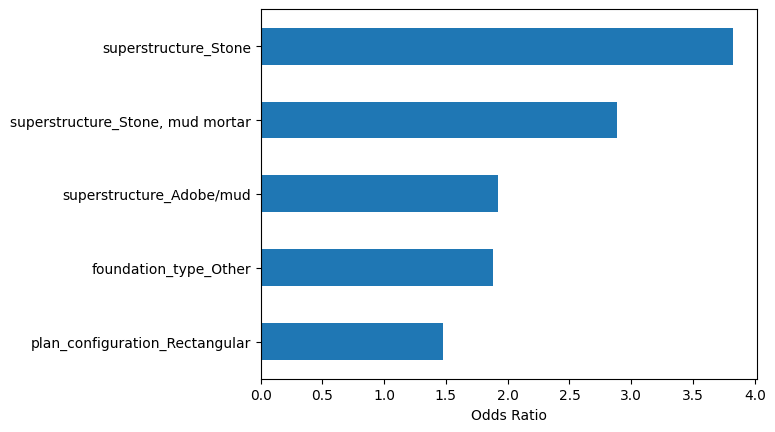

In [19]:
# Horizontal bar chart, five largest coefficients
odds_ratio.tail().plot(kind="barh")
plt.xlabel("Odds Ratio");

The visualization above shows that buildings that have a superstucture of Stone are 4 times more likely to experience severe damage in the event of an earthquake.
Any feature with odds ratio over 1 means there's an increase in the likelihood that it will get severely damaged in the event of an earthquake,

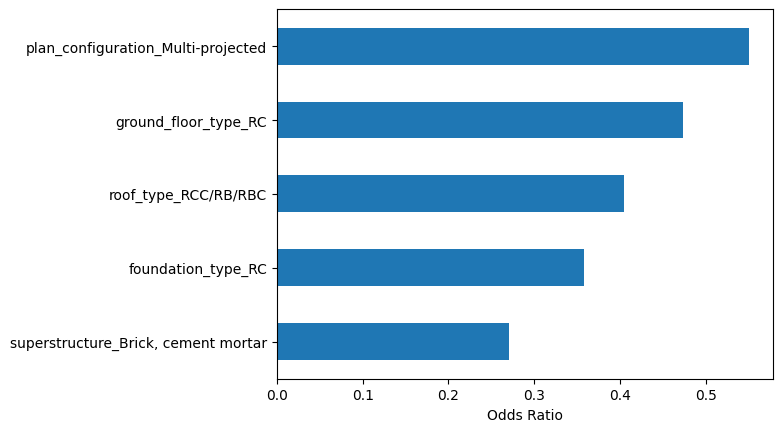

In [21]:
# Horizontal bar chart, five smallest coefficients
odds_ratio.head().plot(kind="barh")
plt.xlabel("Odds Ratio");

In the viz above, all the odds ratio are below 1, superstructures with brick, cement and mortar for example were 75 times less likely to get severely damaged in the event of an earthquake.
If you look closely, you'd notice most of the features here have RC(Reinforced Concrete) and during EDA, in the foundation_pivot plot, foundations built with reinforced concrete were the least likely to get severely damaged in the event of an earthquake.